In [1]:
# Make sure to upgrade TensorFlow to 2.7.0!!!
# conda activate PIC16B
# pip install tensorflow==2.7.0

# First we need to read in the required packages
import cv2,os
import numpy as np
# from tensorflow.keras.utils import np_utils
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.7.0


# Data Visualization

For the masked faces data set, around 250 images are from the Real-World Masked Face Dataset (RMFD), another around 400 images are from the Simulated Masked Face Dataset (SMFD).

Here are some of the examples from the Real-World Masked Face Dataset

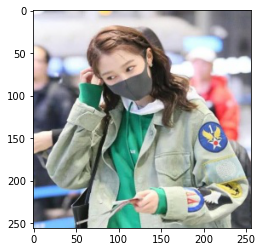

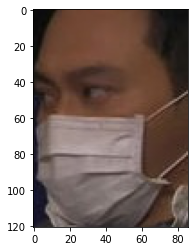

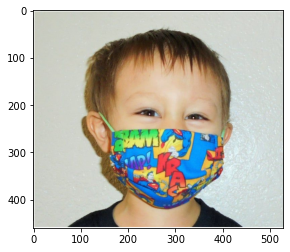

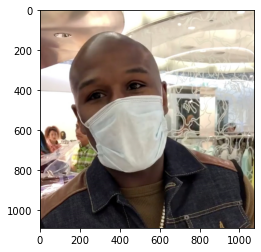

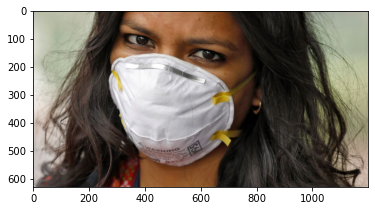

In [3]:
# List of file names
masks_list1 = ["data/with_mask/000 copy 36.jpg", 
               "data/with_mask/0_0_0 copy 21.jpg", 
               "data/with_mask/2398.png", 
               "data/with_mask/with_mask381.jpg",
              "data/with_mask/with_mask316.jpg"]
# Loop through all images, display them
for x in masks_list1:
    # Read in the image
    image = mpimg.imread(x)
    # Show it
    plt.imshow(image)
    plt.show()

# Data Preprocessing

In [4]:
# Create an empty dictionary to store data
data_path='data'
categories=['without_mask', 'with_mask']
# labels: without_mask, with_mask
labels=[i for i in range(0, len(categories))]

# Create an empty dictionary with keys = labels
label_dict=dict(zip(categories,labels))

print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [18]:
# Loop through the datasets, preprocess each image, 
# and append the preprocessed image to the empty dictionary created above
img_size=100
data=[]
target=[]


for category in categories:
    # Construct path to each folder ('without_mask', 'with_mask')
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
    
    # Remove ".DS_Store" from the list of image names
    if '.DS_Store' in img_names:
        img_names.remove('.DS_Store')
    # Loop through images in each folder
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:                
            # Resizing the gray scale into 100x100, since we need a fixed common size for all the images in the dataset           
            resized=cv2.resize(img,(img_size,img_size))
            #appending the image and the label(categorized) into the list (dataset)
            data.append(resized)
            target.append(label_dict[category])
            
        except Exception as e:
            print(img_name)
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here.

In [19]:
"""
In this part we convert the images and targets into array form, 
and convert the targets into binary representations
"""

data=np.array(data)
# Reshape data to a smaller size
# data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

# Covert integer vector to binary class matrix
new_target=utils.to_categorical(target)

In [21]:
# baseline performance
sum(target)/len(target)

0.6301050175029171

In [22]:
# Split data into training & testing sets
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)

# Model

In [29]:
"""
In our model we include:
1. a preprocessor
2. data augmentation: randomly flipping & rotating the images
3. two convolutional 2D layers
4. two max pooling layers
5. two dropout layers to avoid overfitting 
6. a flatten layer
7. and finally two dense layers to match the number of classes in the output
"""

# create a preprocessing layer
i = tf.keras.Input(shape=(100, 100, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

model = tf.keras.Sequential([
    # preprocessing
    preprocessor,
    # data augmentation
    layers.RandomFlip('horizontal'), 
    layers.RandomRotation(0.05),
    # The first CNN layer is a Convolution layer of a kernel size 3*3
    # It learns the base features and applies'relu' nonlinear transformation.
    # Also specifying the input shape here to be 100
    layers.Conv2D(100,(3,3), activation=layers.LeakyReLU(), input_shape=data.shape[1:]),
    # MaxPooling2D((2, 2)) 2*2 the size of window to find the max
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.5) force the model to not fit too closely, help relieve overfitting
    layers.Dropout(0.5),
    # The second convolution layer
    layers.Conv2D(100,(3,3), activation=layers.LeakyReLU()),
    # MaxPooling layer
    layers.MaxPooling2D((2, 2)),
    # Flatten layer to stack the output convolutions from second convolution layer
    layers.Flatten(),
    # layers.Dropout(0.5) force the model to not fit too closely, help relieve overfitting
    layers.Dropout(0.5),
    # Dense layer of 25 neurons
    layers.Dense(25, activation=layers.LeakyReLU()),
    layers.Dense(2,activation='softmax')
])

In [30]:
model.build(data.shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 100, 100, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 100, 100, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 100, 100, 3)      0         
 tation)                                                         
                                                                 
 conv2d_2 (Conv2D)           (None, 98, 98, 100)       2800      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 100)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 49, 49, 100)      

In [31]:
# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# from_logits=True compute softmax when evaluting loss function
# metrics=['accuracy'] want to see how accurate on the data

# fit the model on 80% of the training set, evaluate on the rest
history = model.fit(train_data,
                     train_target, 
                     epochs=20,
                     validation_split=0.2)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
58/58 [==============================] - ETA: 0s - loss: 0.7259 - accuracy: 0.7957WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x14b22b050> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and att

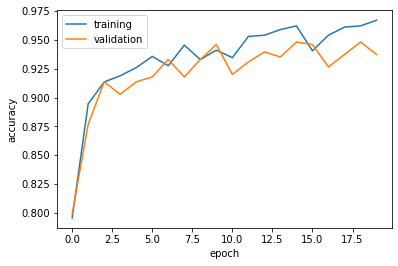

In [32]:
"""
Our results proved to be pretty precise and there
is no apparent sign of overfitting.
"""
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy") # gca: get current axis 
plt.legend()

In [33]:
print(model.evaluate(test_data,test_target))

9/9 [==============================] - 1s 79ms/step - loss: 0.1685 - accuracy: 0.9496
[0.1684819757938385, 0.9496123790740967]
